##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 4 - Google Search grounding with the Gemini API

Welcome back to the Kaggle 5-day Generative AI course!

In this optional notebook, you will use [Google Search](https://google.com/) results with the Gemini API in a technique called grounding, where the model is connected to verifiable sources of information. Using search grounding is similar to using the RAG system you implemented earlier in the week, but the Gemini API automates a lot of it for you. The model generates Google Search queries and invokes the searches automatically, retrieving relevant data from Google's index of the web and providing links to search suggestions that support the query, so your users can verify the sources.

## New in Gemini 2.0

Gemini 2.0 Flash provides a generous Google Search quota as part of the [free tier](https://ai.google.dev/pricing). If you switch models back to 1.5, you will need to [enable billing](https://aistudio.google.com/apikey) to use Grounding with Google Search, or you can [try it out in AI Studio](https://aistudio.google.com/). See the [earlier versions of this notebook](https://www.kaggle.com/code/markishere/day-4-google-search-grounding?scriptVersionId=207458162) for guidance. 

## Optional: Use Google AI Studio

If you wish to try out grounding with Google Search, follow this section to try it out using the AI Studio interface. Or skip ahead to the `API` section to try the feature here in your notebook.

### Open AI Studio

Start by going to [AI Studio](https://aistudio.google.com/prompts/new_chat). You should be in the "New chat" interface.

Search Grounding is best with `gemini-2.0-flash`, but try out `gemini-1.5-flash` too.

![New chat in AI Studio](https://storage.googleapis.com/generativeai-downloads/kaggle/ais-newchat.png)

### Ask a question

Now enter a prompt into the chat interface. Try asking something that is timely and might require recent information to answer, like a recent sport score. For this query, grounding will be **disabled** by default.

This screenshow shows the response for `What were the top halloween costumes this year?`. Every execution will be different but typically the model talks about 2023, and hedges its responses saying it doesn't have access to specific information resulting in a general comment, rather than specific answers.

![Sample question-answer pair without grounding](https://storage.googleapis.com/generativeai-downloads/kaggle/cricket-ungrounded.png)

### Enable grounding

On the right-hand sidebar, under the `Tools` section. Find and enable the `Grounding` option.

![Enable grounding button](https://storage.googleapis.com/generativeai-downloads/kaggle/enable-grounding.png)

Now re-run your question by hovering over the user prompt in the chat history, and pressing the Gemini ✨ icon to re-run your prompt.

![Re-run prompt button](https://storage.googleapis.com/generativeai-downloads/kaggle/re-run-button.png)

You should now see a response generated that references sources from Google Search.

![Response with grounded sources from Google!](https://storage.googleapis.com/generativeai-downloads/kaggle/cricket-grounded.png)


### Try your own queries

Explore this interface and try some other queries. Share what works well in the [Discord](https://discord.com/channels/1101210829807956100/1303438361117069363)! You can start from [this blank template](https://aistudio.google.com/app/prompts/1FZtxKLFZIJ1p_0rICu8K2CNIF1tkAnf4) that has search grounding enabled.

The remaining steps require an API key with billing enabled. They are not required to complete this course; if you have tried grounding in AI Studio you are done for this notebook.

## Use the API

Start by installing and importing the Gemini API Python SDK.

In [1]:
# Uninstall packages from Kaggle base image that are not needed.
!pip uninstall -qy jupyterlab jupyterlab-lsp
# Install the google-genai SDK for this codelab.
!pip install -qU 'google-genai==1.7.0'

In [2]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

'1.7.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

### Automated retry

In [5]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

## Use search grounding

### Model support

Search grounding is available in a limited set of models. Find a model that supports it on [the models page](https://ai.google.dev/gemini-api/docs/models/gemini).

In this guide, you'll use `gemini-2.0-flash`.

### Make a request

To enable search grounding, you specify it as a tool: `google_search`. Like other tools, this is supplied as a parameter in `GenerateContentConfig`, and can be passed to `generate_content` calls as well as `chats.create` (for all chat turns) or `chat.send_message` (for specific turns).


<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/app/prompts/1GTkO-gH4vd6G7LpBJ6Ay7U1OaJer7yDD"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [8]:
# Ask for information without search grounding.
response = client.models.generate_content(
    model='gemini-2.0-flash',
    # contents="When and where is Billie Eilish's next concert?"
    contents="Who performed in the last SuperBowl Halftime Show?")

Markdown(response.text)

Rihanna performed in the Super Bowl LVII Halftime Show.


Now try with grounding enabled.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/14lDR0VjSni6BEUCZUBqj5PzTn3J194Th"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [10]:
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="Who performed in the last SuperBowl Halftime Show?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

The most recent Super Bowl Halftime Show, Super Bowl LX in 2026, featured Bad Bunny headlining, with special appearances by Lady Gaga and Ricky Martin.

Here's a list of the previous halftime show performers:
*   **2025:** Kendrick Lamar with special guest SZA.
*   **2024:** Usher with special guests Alicia Keys, Jermaine Dupri, H.E.R., will.i.am, Lil Jon, Ludacris.
*   **2023:** Rihanna.
*   **2022:** Eminem, Dr. Dre, Snoop Dogg, Kendrick Lamar, and Mary J. Blige.
*   **2021:** The Weeknd.
*   **2020:** Shakira, Jennifer Lopez, Bad Bunny, J Balvin, Emme Muñiz.


### Response metadata

When search grounding is used, the model returns extra metadata that includes links to search suggestions, supporting documents and information on how the supporting documents were used.

Each "grounding chunk" represents information retrieved from Google Search that was used in the grounded generation request. Following the URI will take you to the source.

In [11]:
while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
    # If incomplete grounding data was returned, retry.
    rc = query_with_grounding()

chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

cbssports.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHahMgF97UJOcNHJzb_413Io40vVRrZUPTJx906XC8TlD-4rHOcI0nvsrDOZbOeyr_-hls5ObMm6bSGsfIaPbzRKKP_weGkE4uX6wFsSiQAz3zcyVjRgrJz2TiRolEskNHSvFueglSG0_oUCRZFVpE8E_g7StoF_Hw-VnGPKsLAkLCD4sCHQsR8CUzardU=
nbcsports.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEioOZ_rfn7ikn9QZUU7Liy_kcoxewJOkqp0G6mN8sjcYIdgxqWQ5dKm8FLNutSpDdIqUFvyI5-1jmST6mbAJ2rbzVYknWy8zAiNzRC0jF7REt1kCYTKSrYyap3tYOwRy8kwJq9ikBAnBHGrVYFqgz5MZ-T9vTx4PHamtoyITpKHpyzDU_uvbzPB9c7pRmKL3dJOv9gBCZzt6hfSA==
forbes.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGcOXu-OEdG4RtNee_mC1NZxlpbT9VtoDlnA-gXEsAcboj2oIiduhmKUE3M6paFc17PyDfVaZlQL91ZnJcyu5F6OiYrO_aeMg7dcoZ9IvSeOwuEW7KEyyEPFDk7FrkZ2n-2q3oOxX44oWsGWgFXeKVi4LUGFU1gKheQpe4EgagAULDsKt0djN4yBhf-Ya1UPgoxjIivMoSqeA1GmwqkN-peRl-4BZ8qVKk=
wikipedia.org: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGPTohBEJQAo8teAy5fEpHYKhbQUSQEGD5lank5

As part of the response, there is a standalone styled HTML content block that you use to link back to relevant search suggestions related to the generation.

In [12]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

The `grounding_supports` in the metadata provide a way for you to correlate the grounding chunks used to the generated output text.

In [13]:
from pprint import pprint

supports = rc.grounding_metadata.grounding_supports
for support in supports:
    pprint(support.to_json_dict())

{'confidence_scores': [0.88339734, 0.011058197, 0.006513104],
 'grounding_chunk_indices': [0, 1, 2],
 'segment': {'end_index': 150,
             'text': 'The most recent Super Bowl Halftime Show, Super Bowl LX '
                     'in 2026, featured Bad Bunny headlining, with special '
                     'appearances by Lady Gaga and Ricky Martin'}}
{'confidence_scores': [0.6444036, 0.9702839],
 'grounding_chunk_indices': [1, 0],
 'segment': {'end_index': 260,
             'start_index': 153,
             'text': "Here's a list of the previous halftime show performers:\n"
                     '*   **2025:** Kendrick Lamar with special guest SZA'}}
{'confidence_scores': [0.96701425],
 'grounding_chunk_indices': [0],
 'segment': {'end_index': 367,
             'start_index': 262,
             'text': '*   **2024:** Usher with special guests Alicia Keys, '
                     'Jermaine Dupri, H.E.R., will.i.am, Lil Jon, Ludacris'}}
{'confidence_scores': [0.8723684, 0.9434719],
 'grou

These supports can be used to highlight text in the response, or build tables of footnotes.

In [14]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        rc.content.parts[0].text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

Supported text:

 * The most recent Super Bowl Halftime Show, Super Bowl LX in 2026, featured Bad Bunny headlining, with special appearances by Lady Gaga and Ricky Martin<sup>[1]</sup><sup>[2]</sup><sup>[3]</sup>

 * Here's a list of the previous halftime show performers:
*   **2025:** Kendrick Lamar with special guest SZA<sup>[2]</sup><sup>[1]</sup>

 * *   **2024:** Usher with special guests Alicia Keys, Jermaine Dupri, H.E.R., will.i.am, Lil Jon, Ludacris<sup>[1]</sup>

 * *   **2023:** Rihanna<sup>[2]</sup><sup>[1]</sup>

 * Blige<sup>[4]</sup><sup>[1]</sup>

 * *   **2021:** The Weeknd<sup>[3]</sup><sup>[2]</sup><sup>[1]</sup>

 * *   **2020:** Shakira, Jennifer Lopez, Bad Bunny, J Balvin, Emme Muñiz.<sup>[1]</sup><sup>[2]</sup>

Citations:

1. [cbssports.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHahMgF97UJOcNHJzb_413Io40vVRrZUPTJx906XC8TlD-4rHOcI0nvsrDOZbOeyr_-hls5ObMm6bSGsfIaPbzRKKP_weGkE4uX6wFsSiQAz3zcyVjRgrJz2TiRolEskNHSvFueglSG0_oUCRZFVpE8E_g7StoF_Hw-VnGPKsLAkLCD4sCHQsR8CUzardU=)
2. [nbcsports.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEioOZ_rfn7ikn9QZUU7Liy_kcoxewJOkqp0G6mN8sjcYIdgxqWQ5dKm8FLNutSpDdIqUFvyI5-1jmST6mbAJ2rbzVYknWy8zAiNzRC0jF7REt1kCYTKSrYyap3tYOwRy8kwJq9ikBAnBHGrVYFqgz5MZ-T9vTx4PHamtoyITpKHpyzDU_uvbzPB9c7pRmKL3dJOv9gBCZzt6hfSA==)
3. [forbes.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGcOXu-OEdG4RtNee_mC1NZxlpbT9VtoDlnA-gXEsAcboj2oIiduhmKUE3M6paFc17PyDfVaZlQL91ZnJcyu5F6OiYrO_aeMg7dcoZ9IvSeOwuEW7KEyyEPFDk7FrkZ2n-2q3oOxX44oWsGWgFXeKVi4LUGFU1gKheQpe4EgagAULDsKt0djN4yBhf-Ya1UPgoxjIivMoSqeA1GmwqkN-peRl-4BZ8qVKk=)
4. [wikipedia.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGPTohBEJQAo8teAy5fEpHYKhbQUSQEGD5lank5xbj44nf1bKtK46w7OqTX7CFwsjsgYgH7hOgW_Q9GPHtLPiJokSSGDzixqGtHR6jvowCnyqOqy1M66BN-oNRNRD5Bcdh3KsblhkqxXxkZ-aby8AZbNUgi9SY=)


## Search with tools

In this example, you'll use enable the Google Search grounding tool and the code generation tool across two steps. In the first step, the model will use Google Search to find the requested information and then in the follow-up question, it generates code to plot the results.

This usage includes textual, visual and code parts, so first define a function to help visualise these.

In [15]:
from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

Now start a chat asking for some information. Here you provide the Google Search tool so that the model can look up data from Google's Search index.

In [16]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0,
)

chat = client.chats.create(model='gemini-2.0-flash')

response = chat.send_message(
    message="What were the current medal tallies, by top-5 countries, for the 2026 winter olympics?",
    config=config_with_search,
)

show_response(response)

As of February 10, 2026, at 1 p.m. UTC, here are the top 5 countries in the medal standings for the 2026 Winter Olympics:

1.  Norway: 6 Gold, 1 Silver, 4 Bronze, 11 Total Medals
2.  Italy: 2 Gold, 2 Silver, 7 Bronze, 11 Total Medals
3.  Japan: 2 Gold, 2 Silver, 3 Bronze, 7 Total Medals
4.  Switzerland: 3 Gold, 1 Silver, 1 Bronze, 5 Total Medals
5.  (Tie) Sweden: 2 Gold, 2 Silver, 1 Bronze, 5 Total Medals
6.  (Tie) Germany: 2 Gold, 1 Silver, 1 Bronze, 5 Total Medals
7.  (Tie) Austria: 2 Gold, 3 Silver, 0 Bronze, 5 Total Medals
8.  (Tie) United States: 2 Gold, 2 Silver, 1 Bronze, 5 Total Medals



----

Continuing the chat, now ask the model to convert the data into a chart. The `code_execution` tool is able to generate code to draw charts, execute that code and return the image. You can see the executed code in the `executable_code` part of the response.

Combining results from Google Search with tools like live plotting can enable very powerful use cases that require very little code to run.

In [17]:
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)

response = chat.send_message(
    message="Now plot this as a seaborn chart. Break out the medals too.",
    config=config_with_code,
)

show_response(response)

Okay, I can help you visualize this data using a Seaborn chart. To do this effectively, I need to represent the data in a format that Seaborn can easily understand. I'll use a Python dictionary to store the medal counts for each country, and then convert it into a Pandas DataFrame. After that, I'll use Seaborn to create a stacked bar chart showing the medal distribution for the top 5 countries.



----

{'executable_code': {'code': "import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Data for the medal table\ndata = {\n    'Country': ['Norway', 'Italy', 'Japan', 'Switzerland', 'Sweden', 'Germany', 'Austria', 'United States'],\n    'Gold': [6, 2, 2, 3, 2, 2, 2, 2],\n    'Silver': [1, 2, 2, 1, 2, 1, 3, 2],\n    'Bronze': [4, 7, 3, 1, 1, 1, 0, 1]\n}\n\n# Create a Pandas DataFrame\ndf = pd.DataFrame(data)\n\n# Melt the DataFrame to long format for Seaborn\ndf_melted = df.melt(id_vars='Country', var_name='Medal', value_name='Count')\n\n# Filter for the top 5 countries\ntop_5_countries = df['Country'].head(5).tolist()\ndf_melted = df_melted[df_melted['Country'].isin(top_5_countries)]\n\n# Create the stacked bar chart\nplt.figure(figsize=(10, 6))  # Adjust figure size for better readability\nsns.barplot(x='Country', y='Count', hue='Medal', data=df_melted, palette=['#FFD700', '#C0C0C0', '#CD7F32'])  # Gold, Silver, Bronze colors\nplt.title('2026 Winter Olympics Me

----

{'code_execution_result': {'outcome': 'OUTCOME_FAILED', 'output': '11:1: "}" can only be used to close a block\n\nstderr output:\n\n'}}


----

I encountered an error when trying to execute the code. It seems like there's a syntax error related to the closing curly brace. I'll correct the code and try again.


----

{'executable_code': {'code': "import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Data for the medal table\ndata = {\n    'Country': ['Norway', 'Italy', 'Japan', 'Switzerland', 'Sweden', 'Germany', 'Austria', 'United States'],\n    'Gold': [6, 2, 2, 3, 2, 2, 2, 2],\n    'Silver': [1, 2, 2, 1, 2, 1, 3, 2],\n    'Bronze': [4, 7, 3, 1, 1, 1, 0, 1]\n}\n\n# Create a Pandas DataFrame\ndf = pd.DataFrame(data)\n\n# Melt the DataFrame to long format for Seaborn\ndf_melted = df.melt(id_vars='Country', var_name='Medal', value_name='Count')\n\n# Filter for the top 5 countries\ntop_5_countries = df['Country'].head(5).tolist()\ndf_melted = df_melted[df_melted['Country'].isin(top_5_countries)]\n\n# Create the stacked bar chart\nplt.figure(figsize=(10, 6))  # Adjust figure size for better readability\nsns.barplot(x='Country', y='Count', hue='Medal', data=df_melted, palette=['#FFD700', '#C0C0C0', '#CD7F32'])  # Gold, Silver, Bronze colors\nplt.title('2026 Winter Olympics Me

----

{'code_execution_result': {'outcome': 'OUTCOME_FAILED', 'output': '11:1: "}" can only be used to close a block\n\nstderr output:\n\n'}}


----

It seems like the error persists. The error message "}" can only be used to close a block" indicates that there's an issue with how the code is being interpreted, possibly related to the environment or the way the code is being passed to the execution environment. The code itself is syntactically correct and should run without issues in a standard Python environment.

Since I cannot directly display the chart here due to the persistent execution errors, I will describe the chart that *would* be generated:

The chart would be a stacked bar chart with the top 5 countries (Norway, Italy, Japan, Switzerland, and Sweden) on the x-axis. The y-axis would represent the medal count. Each bar would be divided into three colored sections representing the number of Gold (yellow/gold), Silver (gray/silver), and Bronze (brown/bronze) medals for that country. The x-axis labels would be rotated for better readability. The title of the chart would be "2026 Winter Olympics Medal Count (Top 5 Countries)".


----

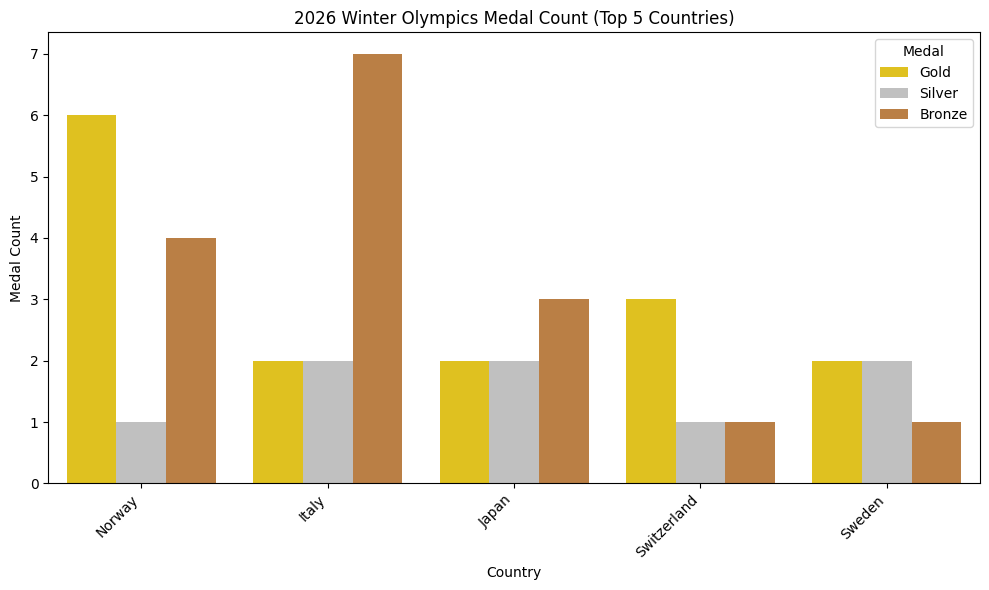

In [ ]:
## Since there was an error with the environment or passing of the code, lets manually test it.
# Copying-pasting and adjusting the code provided by the response.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data for the medal table
data = {
    'Country': ['Norway', 'Italy', 'Japan', 'Switzerland', 'Sweden', 'Germany', 'Austria', 'United States'],
    'Gold': [6, 2, 2, 3, 2, 2, 2, 2],
    'Silver': [1, 2, 2, 1, 2, 1, 3, 2],
    'Bronze': [4, 7, 3, 1, 1, 1, 0, 1]
}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame to long format for Seaborn
df_melted = df.melt(id_vars='Country', var_name='Medal', value_name='Count')

# Filter for the top 5 countries
top_5_countries = df['Country'].head(5).tolist()
df_melted = df_melted[df_melted['Country'].isin(top_5_countries)]

# Create the stacked bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
sns.barplot(x='Country', y='Count', hue='Medal', data=df_melted, palette=['#FFD700', '#C0C0C0', '#CD7F32'])  # Gold, Silver, Bronze colors
plt.title('2026 Winter Olympics Medal Count (Top 5 Countries)')
plt.xlabel('Country')
plt.ylabel('Medal Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()

## Further reading

When using search grounding, there are some specific requirements that you must follow, including when and how to show search suggestions, and how to use the grounding links.  Be sure to read and follow the details in the [search grounding capability guide](https://ai.google.dev/gemini-api/docs/grounding) and the [search suggestions guide](https://ai.google.dev/gemini-api/docs/grounding/search-suggestions).

Also check out some more compelling examples of using search grounding with the Live API in the [cookbook](https://github.com/google-gemini/cookbook/), like [this example that uses Google Maps to plot Search results on a map](https://github.com/google-gemini/cookbook/blob/main/examples/LiveAPI_plotting_and_mapping.ipynb) in an audio conversation, or [this example](https://github.com/google-gemini/cookbook/blob/main/examples/Search_grounding_for_research_report.ipynb) that builds a comprehensive research report.

*- [Mark McD](https://linktr.ee/markmcd)*